# Plot the validation of the tsorb model
Author: Leander Kotzur

Date: 21.03.2018

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import timeseriesmanager as tsm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import os

In [3]:
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [4]:
EXPORT_PATH = os.path.join('plots')

Define mean usage

In [5]:
MEAN_USAGE = 3515

## Read in profiles

### CREST

In [6]:
CREST_GER = pd.read_csv(os.path.join('data','Houshold_load_GER.csv'), index_col = [0])
CREST_GER.index = pd.to_datetime(CREST_GER.index)
CREST_GER = CREST_GER.resample('1h').mean()

Normalize overall load

In [7]:
CREST_GER = CREST_GER.div(CREST_GER.sum().sum()) * MEAN_USAGE

In [8]:
CREST_GER = CREST_GER.rename( columns = {'Cold':'Cooling',
                                               'Consumer Electronics + ICT': 'Consumer apps.',
                                'Electric Space Heating':'Heating',
                                'Water heating':'Hot Water','Wet':'Washing',})

Read single profiles

In [9]:
CREST_single = pd.read_csv(os.path.join('data','SingeHouseHolds.csv'), index_col = 0)
CREST_single.index = pd.to_datetime(CREST_single.index)

Resample and get aggregations of 10 and 100 loads

In [10]:
CREST_single = CREST_single.resample('1h').pad().div(1000)

In [11]:
CREST_10_avg = CREST_single[CREST_single.columns[:10]].mean(axis=1).resample('1h').pad().div(1000)
CREST_10_avg = CREST_10_avg.div(CREST_10_avg.sum()) * MEAN_USAGE

In [12]:
CREST_100_avg = CREST_single[CREST_single.columns[:100]].mean(axis=1).resample('1h').pad().div(1000)
CREST_100_avg = CREST_100_avg.div(CREST_100_avg.sum()) * MEAN_USAGE

### HTW

Average profile

In [13]:
profiles_HTW=tsm.readHTWProfiles(                                sample_mean = True, freq = '60min')
HTW_single = profiles_HTW.div(profiles_HTW.sum()) * MEAN_USAGE
HTW_avg = HTW_single.mean(axis=1)

Single profiles

In [14]:
HTW_single=tsm.readHTWProfiles(sample_mean = False)

### SLP

In [15]:
slp = tsm.readSLP(freq='60min', sample_mean = True, year = 2010)

In [16]:
SLP = slp/slp.sum() *MEAN_USAGE

## Plot the differences

Get the correct colormap

In [17]:
import matplotlib.colors as mcolors
def make_colormap(seq):
    """
    Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

In [18]:
rvb = make_colormap([np.array([2., 61., 100.])/255,
                     np.array([20., 129., 129.])/255,0.25,
                     np.array([20., 129., 129.])/255,
                     np.array([108., 139., 70.])/255,0.5,
                     np.array([108., 139., 70.])/255,
                     np.array([250.,150.,90.])/255,0.75,
                     np.array([250.,150.,90.])/255,
                     np.array([255.,192.,0.])/255, ])

#### Aggregated load validation

In [19]:
colorset = rvb(np.linspace(0, 1, len(CREST_GER.columns)))

Plot loads

/home/leander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


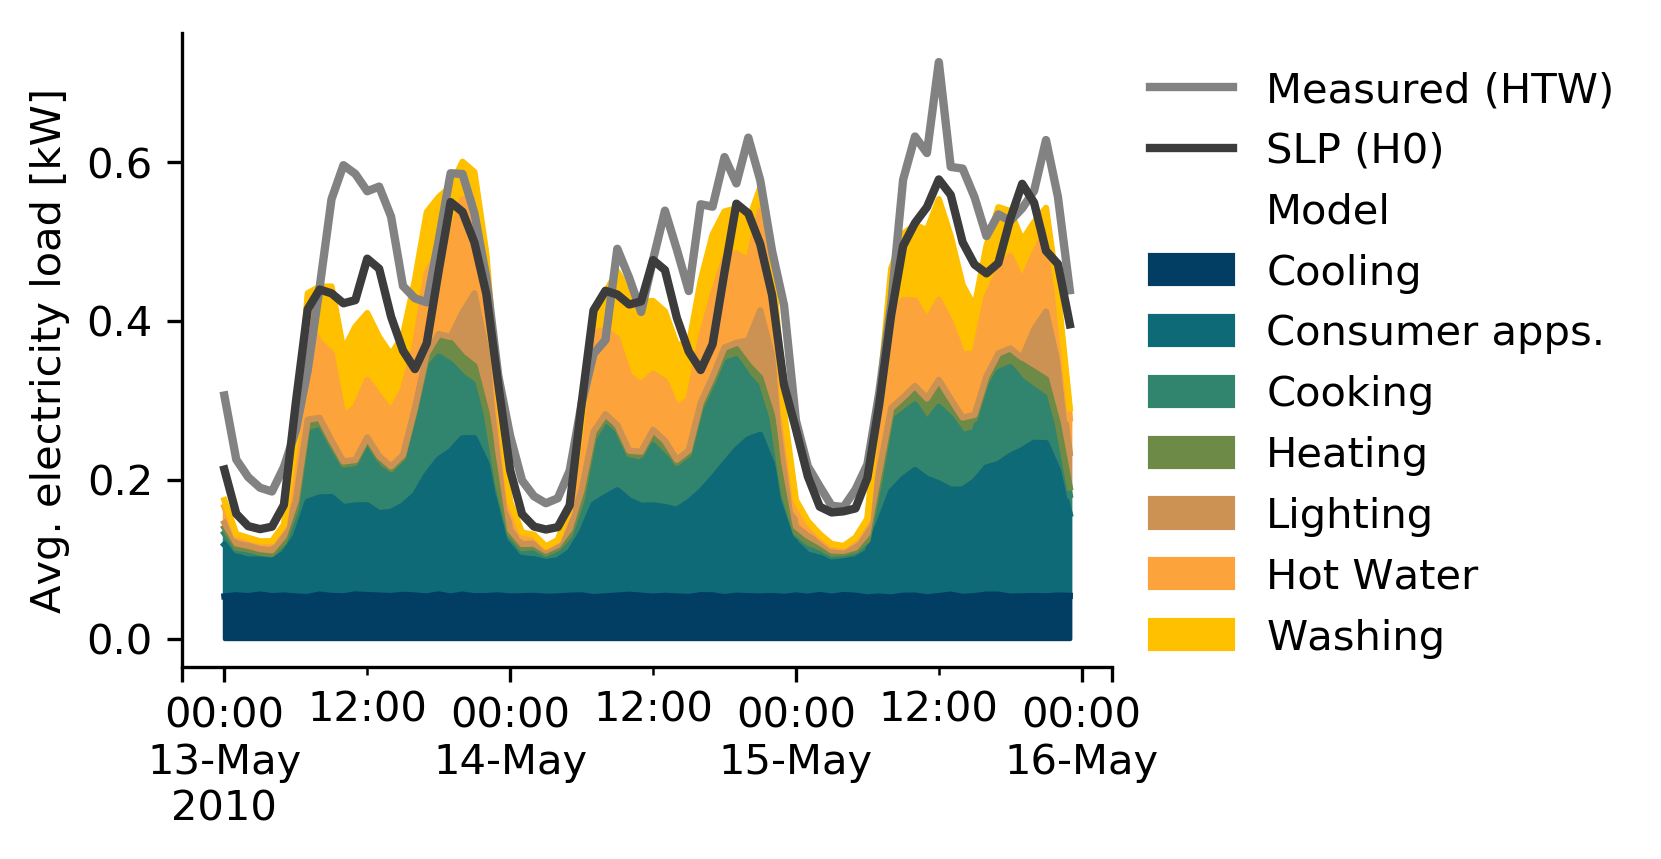

In [31]:
plt.figure(figsize=[4.,2.8],dpi = 300)
ax = plt.subplot(1,1,1)

day1 = '0513'
day2 = '0515'
CREST_GER['2010'+day1:'2010'+day2].plot(ax = ax, kind = 'area', color = colorset)
#dummy for legend
HTW_avg['2010'+day1:'2010'+day2].plot(ax=ax, color = [np.array([130., 130., 130.,255.])/255 ], label = 'Measured (HTW)' , 
                                      lw = 2,)# markersize = 2, marker = 'o')
SLP['2010'+day1:'2010'+day2].plot(ax=ax, color = [np.array([60., 60., 60.,255.])/255],label = 'SLP (H0)' , 
                                  lw = 2,)# marker = 'o', markersize = 2)
HTW_avg['2010'+day1:'2010'+day2].plot(ax=ax, color = [np.array([81., 81., 81.,0.])/255],label = 'Model' , lw = 2)
ax.set_ylabel('Avg. electricity load [kW]')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax.legend(bbox_to_anchor=(1.0, 1.0),edgecolor = 'w')

#### Plot load distribution

In [32]:
comp = pd.DataFrame([CREST_GER.sum(axis=1).values,SLP.values, HTW_avg.values],  
                    index= ['Model (1000 runs)','SLP (H0)','Measured (HTW)'],columns = SLP.index).T

/home/leander/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


/home/leander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


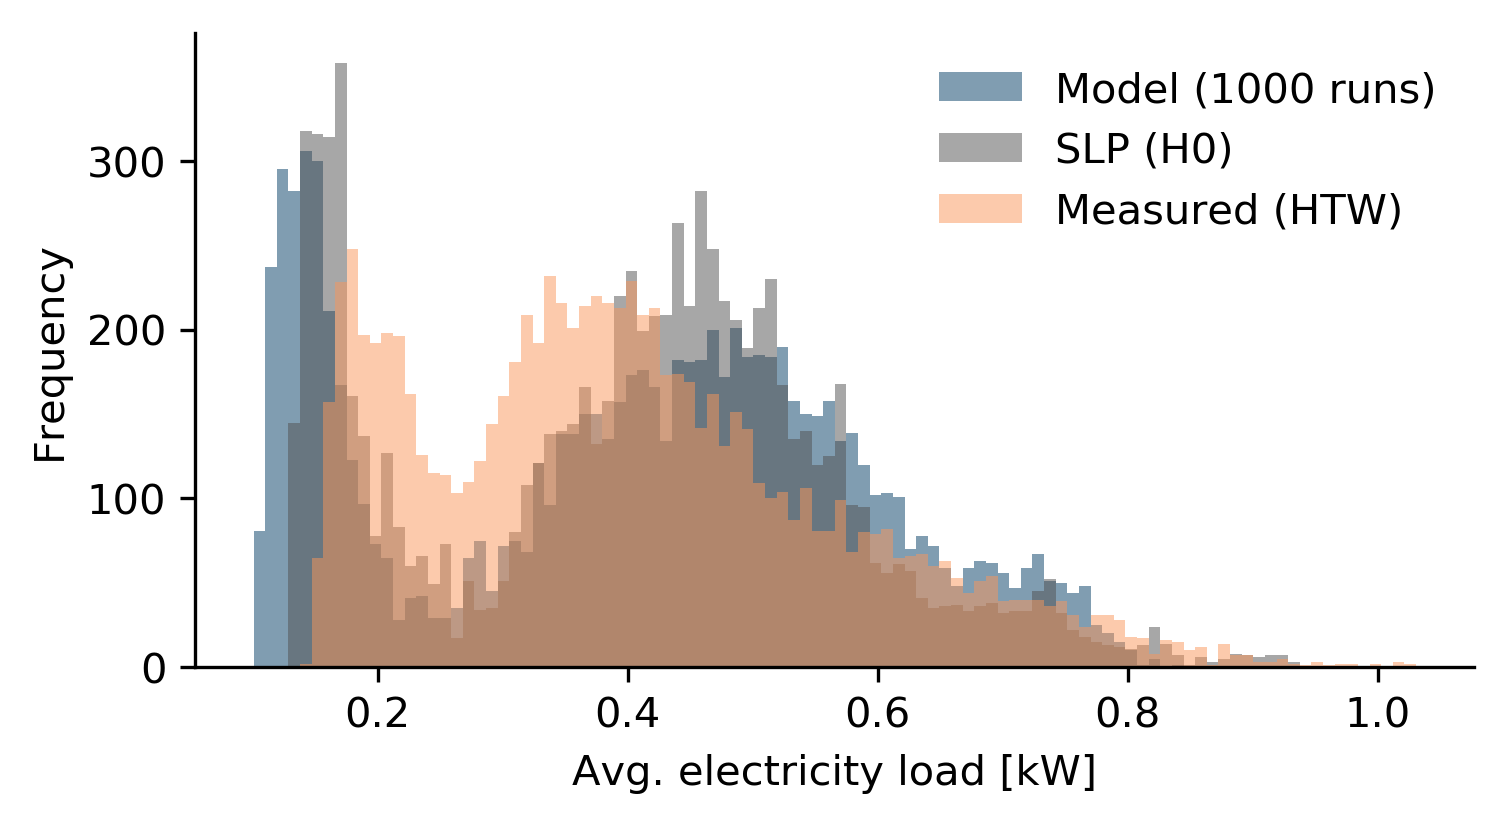

In [34]:
plt.figure(figsize=[5.5,2.8],dpi = 300)
ax = plt.subplot(1,1,1)

ax = comp.plot.hist(alpha = 0.5, bins=100, colors = [ np.array([2., 61., 100.,255.])/255,
                                               np.array([81., 81., 81.,255.])/255,
                                               np.array([250.,150.,90.,255.])/255,],
                   ax = ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Avg. electricity load [kW]')

ax.legend(bbox_to_anchor=(1.0, 1.0),edgecolor = 'w')

import seaborn as sns
plt.figure(figsize=[150./25.4,2.8],dpi = 300)
ax = plt.subplot(1,1,1)
sns.violinplot(data = error, palette=[ np.array([2., 61., 100.,255.])/255,
                                      np.array([108., 139., 70.])/255,
                                               np.array([230.,150.,70.,255.])/255,],
               ax = ax, linewidth = 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_ylabel('Error [kW]')

plt.savefig(os.path.join(EXPORT_PATH,'method_distProfileError.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(EXPORT_PATH,'png','method_distProfileError.png'), bbox_inches='tight')

In [35]:
comp.corr()

,Model (1000 runs),SLP (H0),Measured (HTW)
Model (1000 runs),1.000000,0.924888,0.887416
SLP (H0),0.924888,1.000000,0.881801
Measured (HTW),0.887416,0.881801,1.000000


Plot error between loads

In [36]:
error = pd.DataFrame(index = CREST_GER.index)
error['HTW to SLP'] = SLP - HTW_avg
error['SLP to Model'] = CREST_GER.sum(axis=1) - SLP
error['Model to HTW'] = HTW_avg - CREST_GER.sum(axis=1) 

/home/leander/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
/home/leander/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1804: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


Text(0.5,0,'Deviation between the load profiles [kW]')

/home/leander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


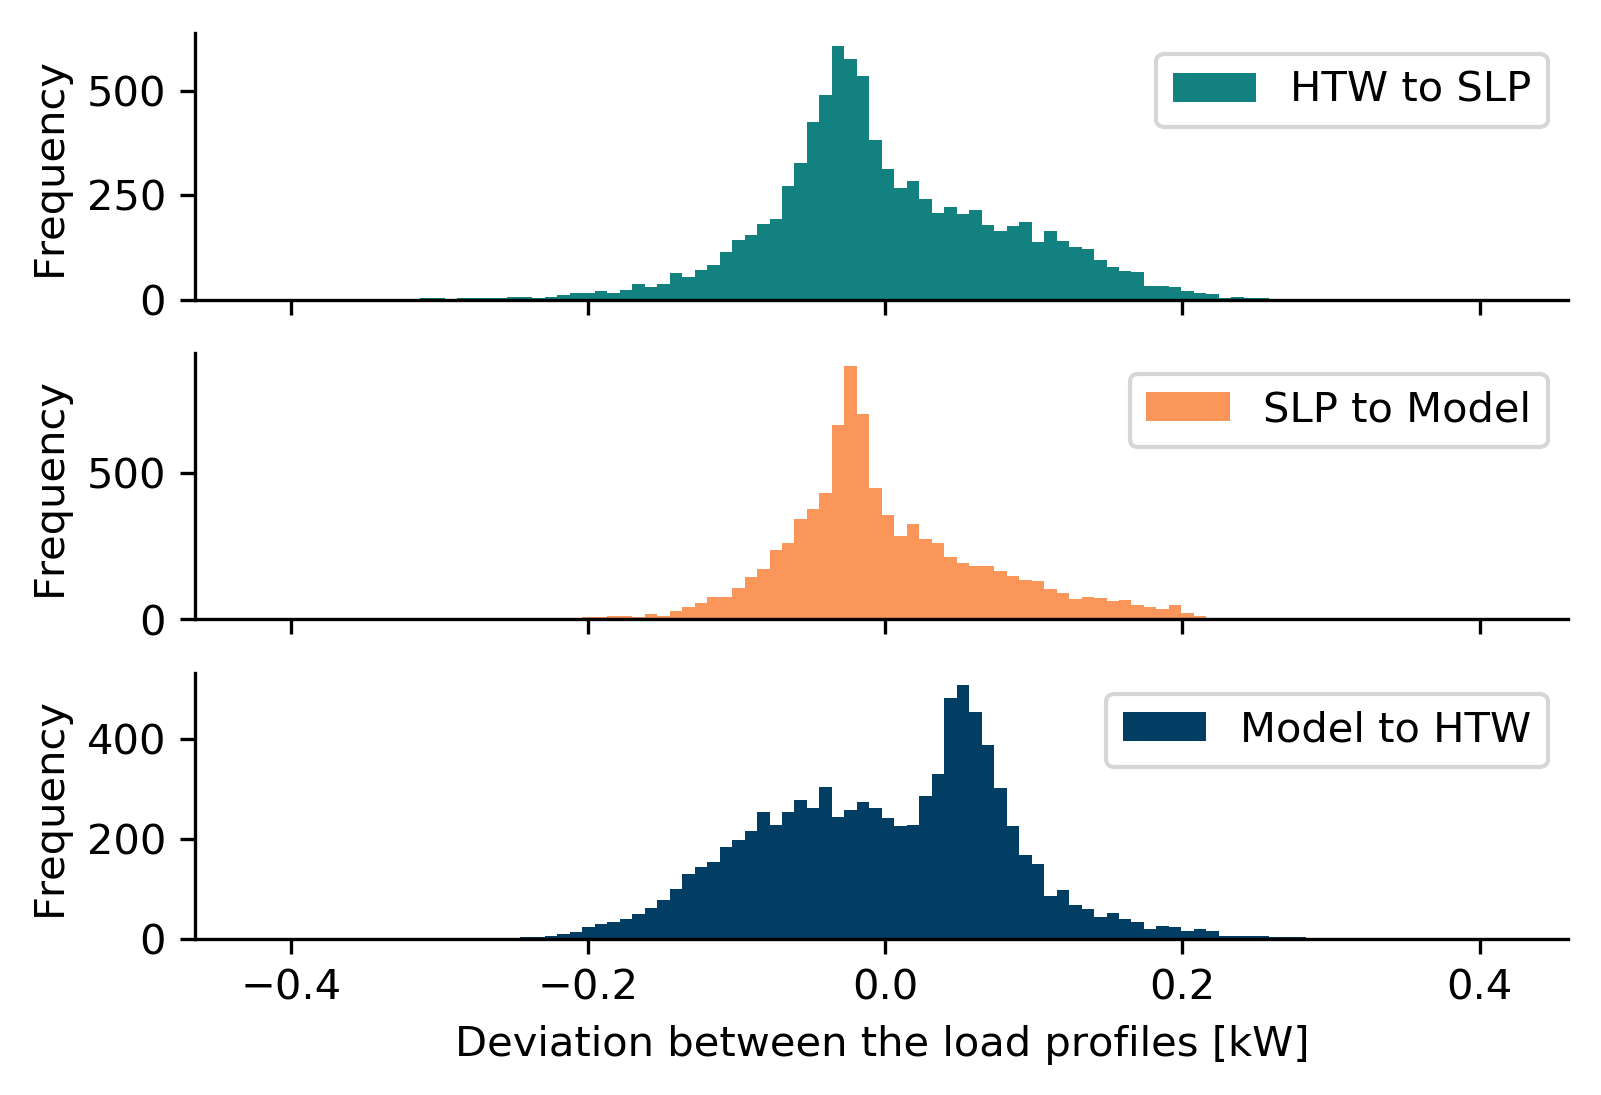

In [37]:
plt.figure(figsize=[150./25.4,4],dpi = 300)
ax = plt.subplot(1,1,1)

axes = error.plot.hist(subplots=True,alpha = 1, bins=100, colors = [ np.array([20., 129., 129.,255.])/255,
                                                                    np.array([250.,150.,90.,255.])/255,
                                                                    np.array([2., 61., 100.,255.])/255,], 
                       sharex=True, ax = ax)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
ax.set_xlabel('Deviation between the load profiles [kW]')


#### Validate device share load

Compare with BDEW values

In [39]:
deviceShare = pd.DataFrame([CREST_GER.sum().div(CREST_GER.sum().sum()*0.01).to_dict(),
                            {'Consumer apps.': 25.6,
                            'Cooling': 16.7,
                            'Hot Water': 14.8,
                            'Washing': 12.4,
                            'Cooking': 9.8,
                            'Lighting': 8.1,
                            'Other': 12.5,}], index = ['Model', 'BDEW'])

In [40]:
deviceShare = deviceShare.rename(columns = {'Consumer apps.': 'Consumer\napps.' })

In [41]:
PLOT_ORDER = ['Lighting','Washing','Cooling','Hot Water','Cooking','Consumer\napps.','Heating','Other']

In [42]:
def testLabel(val):
    if val>3:
        return str(round(val,1))+'%'
    else:
        return ''

In [43]:
def pieCostPlot(plotdata, ax,colorset ,angle= 0, textsize =10, labeltolerance = 0.01, explodetol = 0.3):
    explode = plotdata.div(plotdata.sum()) <explodetol
    explode = explode.astype(float).div(plotdata.div(plotdata.sum())).div(1000)
    explode[explode>explodetol] = explodetol
    explode = explode+0.005

    labels = pd.Series(plotdata.index,index=plotdata.index)
    labels[    plotdata.div(plotdata.sum()) <labeltolerance] = ''

    plotdata.plot(kind='pie',colors=colorset,ax=ax,legend = False, explode = explode, labeldistance=1.05, labels = labels,
                 startangle=angle, radius = 1, textprops = {'fontsize':textsize}, fontsize = textsize) #,autopct='%.1f' 
    plotdata.plot(kind='pie',colors='w',ax=ax,legend = False, pctdistance =1.35, labels = None,
                 startangle=angle, radius = .6,autopct = testLabel, textprops = {'color':'k', 
                                                                                 'fontsize': textsize-2}) 
    #draw circle
    centre_circle = plt.Circle((0,0),0.60,fc='white')
    ax.add_artist(centre_circle)
    ax.axis('equal')
    ax.set_ylabel('')
    return ax, plotdata

Text(0,0,'Germany\n2013\n(BDEW)')

/home/leander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


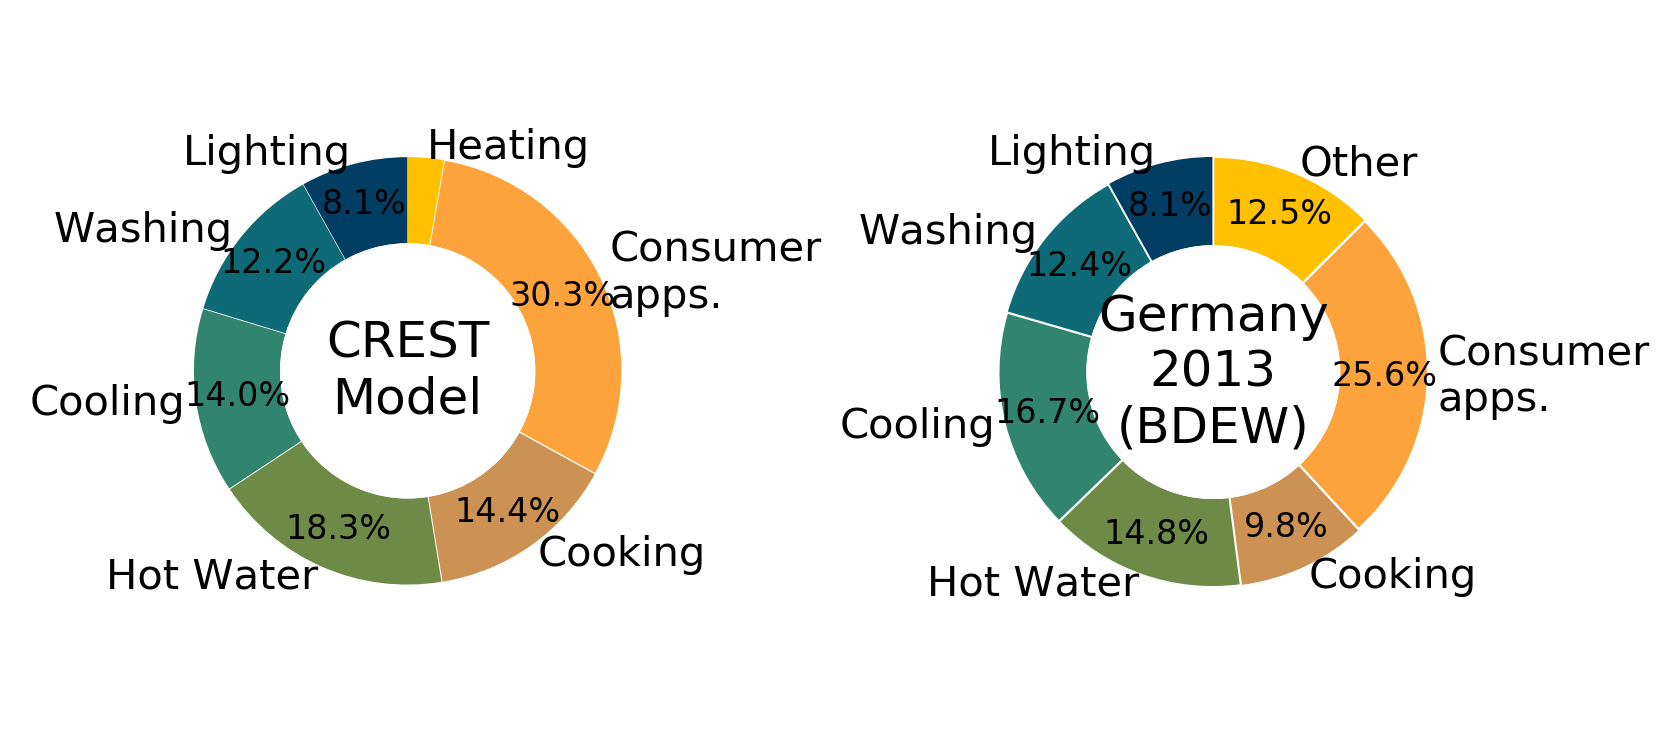

In [44]:
textsize = 10
fig, axes = plt.subplots(figsize=[5.5,3],  nrows = 1 ,ncols = 2,   dpi = 300,
                         gridspec_kw = {'width_ratios':[1, 1],
                                       'wspace': 0.7,})
ax,plotdata = pieCostPlot(deviceShare[PLOT_ORDER].T['Model'].dropna(), 
                          axes[0],colorset,angle = 90,textsize = textsize,
                          explodetol = 0, labeltolerance = 0.001)
ax.text(0,0, 'CREST\nModel' , 
        ha = 'center', va = 'center',fontsize = textsize+2)

ax,plotdata = pieCostPlot(deviceShare[PLOT_ORDER].T['BDEW'].dropna(), 
                          axes[1],colorset,angle = 90,textsize = textsize,labeltolerance = 0.001)
ax.text(0,0, 'Germany\n2013\n(BDEW)' , 
        ha = 'center', va = 'center',fontsize = textsize+2)

#### Validate single sorted loads

In [45]:
COL_1 = np.array([2., 61., 100.])/255
COL_2 = np.array([250.,150.,90.])/255
COL_3 = np.array([108., 139., 70.])/255

/home/leander/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


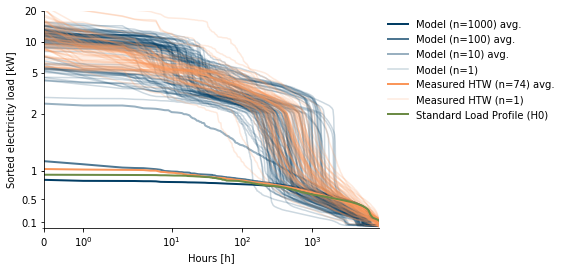

In [46]:
ax = plt.subplot(1,1,1)


HTW_single_sorted = pd.concat([HTW_single[col].sort_values(ascending=False).reset_index() for col in HTW_single], 
                   axis=1, )#ignore_index=True
HTW_single_sorted = HTW_single_sorted.drop('index',axis=1)
CREST_single_sorted =  pd.concat([CREST_single[col].sort_values(ascending=False).reset_index() for col in CREST_single], 
                   axis=1, )#ignore_index=True
CREST_single_sorted = CREST_single_sorted.drop('index',axis=1)
HTW_avg_sorted = HTW_avg.sort_values(ascending=False).reset_index()
HTW_avg_sorted = HTW_avg_sorted.drop('index',axis=1)
SLP_sorted = SLP.sort_values(ascending=False).reset_index()
SLP_sorted = SLP_sorted.drop('index',axis=1)
CREST_GER_sorted = CREST_GER.sum(axis=1).sort_values(ascending=False).reset_index()
CREST_GER_sorted = CREST_GER_sorted.drop('index',axis=1)
CREST_100_sorted = CREST_100_avg.sort_values(ascending=False).reset_index()
CREST_100_sorted = CREST_100_sorted.drop('index',axis=1)
CREST_10_sorted = CREST_10_avg.sort_values(ascending=False).reset_index()
CREST_10_sorted = CREST_10_sorted.drop('index',axis=1)


#plt.fill_between(HTW_single_sorted.index, HTW_single_sorted.min(axis=1), HTW_single_sorted.max(axis=1),
#                color = np.array([0., 81., 130.,80.])/255, linewidth = 0)
    
plt.plot(CREST_GER_sorted.index, CREST_GER_sorted.values, color =  COL_1, alpha = 1,
         label = 'Model (n=1000) avg.',
        linewidth = 2)
plt.plot(CREST_GER_sorted.index, CREST_100_sorted.values, color =  COL_1, alpha = 0.7,
         label = 'Model (n=100) avg.',
        linewidth = 2)
plt.plot(CREST_GER_sorted.index, CREST_10_sorted.values, color =  COL_1, alpha = 0.4,
         label = 'Model (n=10) avg.',
        linewidth = 2)
for i,prof in enumerate(CREST_single_sorted):
    if i == 0:
        plt.plot(HTW_single_sorted.index, CREST_single_sorted[prof].values, color = COL_1,alpha = 0.2,
                label = 'Model (n=1)')
    else:
        plt.plot(HTW_single_sorted.index, CREST_single_sorted[prof].values, color = COL_1,alpha = 0.2,)

plt.plot(HTW_avg_sorted.index, HTW_avg_sorted.values, color =  COL_2, 
         label = 'Measured HTW (n=74) avg.',
        linewidth = 2)
for i,prof in enumerate(HTW_single_sorted):
    if i == 0:
        plt.plot(HTW_single_sorted.index, HTW_single_sorted[prof].values, color = COL_2,alpha = 0.2,
                label = 'Measured HTW (n=1)')
    else:
        plt.plot(HTW_single_sorted.index, HTW_single_sorted[prof].values, color = COL_2,alpha = 0.2,)

        
plt.plot(SLP_sorted.index, SLP_sorted.values, color =  COL_3,
         label = 'Standard Load Profile (H0)',
        linewidth = 2)


ax.set_ylabel('Sorted electricity load [kW]')
ax.set_xlabel('Hours [h]')
ax.set_ylim([0,20])
ax.set_xlim([0,8760])
ax.set_yscale('symlog')
ax.set_xscale('symlog')
ax.set_yticks([ 0.1, 0.5,1,2,5,10,20])
ax.set_yticklabels([0.1, 0.5,1,2,5,10,20])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(bbox_to_anchor=(1.0, 1.0),edgecolor = 'w')